In [2]:
import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# fix and align schemas
cwd = os.getcwd()
dfs = []
for file in os.listdir(cwd):
    if '.xlsx' in file:
        frame = pl.read_excel(
            file,
            schema_overrides={
                'HORA ':pl.String,
                'KILOMETRO ':pl.Float64
            }
        )
        frame = frame.rename(mapping={'TIPO DE VIA':'TIPO DE LA VIA'}, strict=False)
        dfs.append(frame)
df = pl.concat(dfs).lazy()


In [4]:
df.collect_schema()

Schema([('AÑO', Int64),
        ('MES', String),
        ('DIA MES', Int64),
        ('DIA SEMANA', String),
        ('HORA ', String),
        ('RANGO HORA', Int64),
        ('PROFESION/OCUPACION', String),
        ('RANGO MILITAR', String),
        ('NO. DE ACCIDENTE', Int64),
        ('NOMBRE Y APELLIDO DE LA VICTIMA', String),
        ('SEXO', String),
        ('NACIONALIDAD', String),
        ('EDAD', String),
        ('RANGO EDAD', String),
        ('TIPO DE ACCIDENTE', String),
        ('DETALLE DEL ACCIDENTE', String),
        ('CONDICION DE LA VICTIMA', String),
        ('CASCO', String),
        ('MEDIO DE TRANSPORTE DE LA VICTIMA ', String),
        ('MARCA', String),
        ('MODELO ', String),
        ('COLOR', String),
        ('AÑO FABRICACIÓN', String),
        ('PLACA', String),
        ('UBICACIÓN', String),
        ('TIPO DE LA VIA', String),
        ('NOMBRE DE LA VIA', String),
        ('KILOMETRO ', Float64),
        ('TRAMO', String),
        ('SECCION / PARAJE'

In [9]:
q = (
    df
    .unpivot(
        on=[
            'MEDIO DE TRANSPORTE DE LA VICTIMA ',
            'Peatón Atrop. por:',
            'Colisión con: '
        ],
        index=['TOTAL '],
        variable_name='Involucrados',
        value_name='Tipo de vehiculo'
        
    )
    .with_columns(
        pl.col('Involucrados').replace({
            'MEDIO DE TRANSPORTE DE LA VICTIMA ':'Victima',
            'Peatón Atrop. por:':'Peaton',
            'Colisión con: ':'Causante'
        })
    )
    # excluir cuando no hay vehiculo reportado
    .filter(~pl.col('Tipo de vehiculo').is_null())
    .group_by(
        pl.col('Tipo de vehiculo'),
        pl.col('Involucrados')
    )
    .agg(
        pl.col('TOTAL ').sum().alias('Accidentes')
    )
    .with_columns(
        pl
        .col('Accidentes')
        .sum()
        .over(partition_by='Tipo de vehiculo')
        .alias('Total Por Tipo de Vehiculo')
    )
    .with_columns(
        (pl.col('Accidentes') / pl.col('Total Por Tipo de Vehiculo')).alias('Accidentes %')
    )
    .sort(
        by=['Total Por Tipo de Vehiculo'],
        descending=True
    )
    .collect()
)

In [10]:
q

Tipo de vehiculo,Involucrados,Accidentes,Total Por Tipo de Vehiculo,Accidentes %
str,str,i64,i64,f64
"""MOTOCICLETA""","""Causante""",114,867,0.131488
"""MOTOCICLETA""","""Peaton""",29,867,0.033449
"""MOTOCICLETA""","""Victima""",724,867,0.835063
"""CARRO""","""Victima""",79,196,0.403061
"""CARRO""","""Peaton""",16,196,0.081633
…,…,…,…,…
"""VOLTEO Y AUTOBUS""","""Causante""",1,1,1.0
"""CAMIONETA Y JEEPETA""","""Causante""",1,1,1.0
"""LOCOMOTORA""","""Peaton""",1,1,1.0


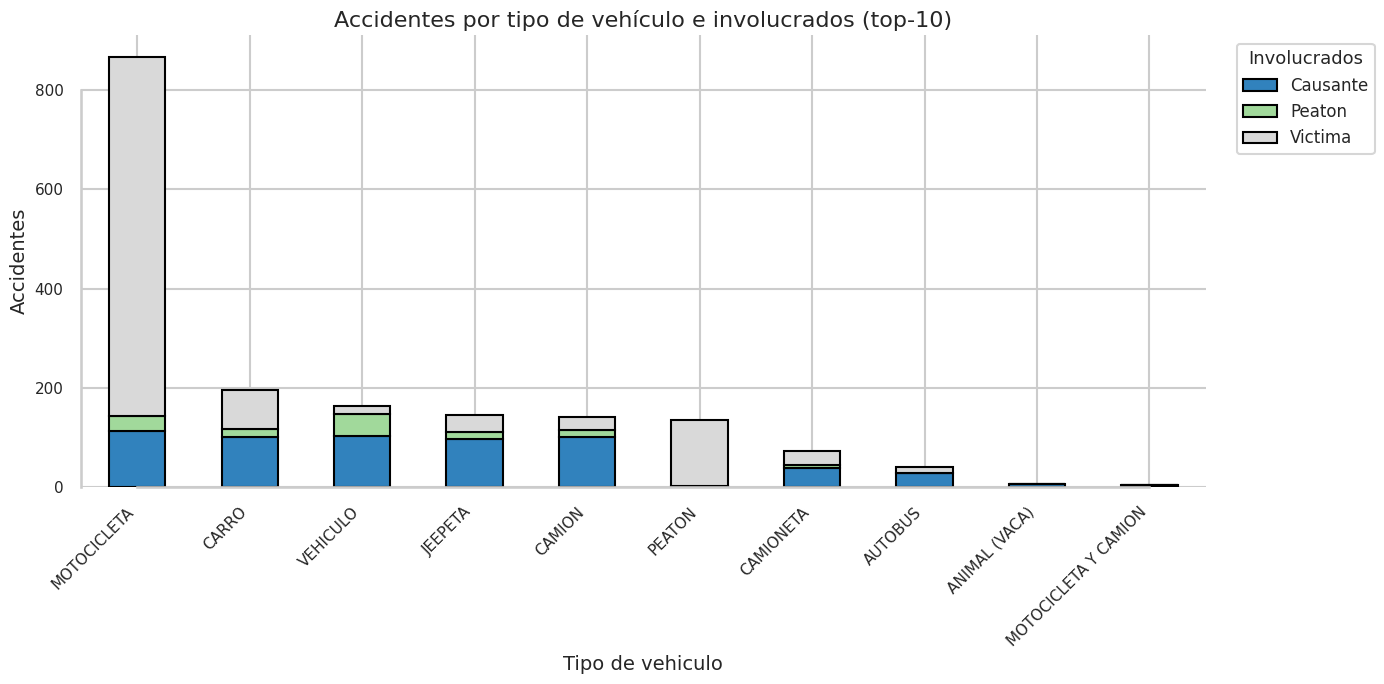

In [26]:
# nicer theme & larger fonts
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13,
})

# turning to pandas for plotting
df_plot = q.to_pandas()

# build a wide table ordered by the total accidents per vehicle type
order = (
    df_plot
    .sort_values('Total Por Tipo de Vehiculo', ascending=False)
    ['Tipo de vehiculo']
    .unique()[:10]          # top‑10, descending
)

wide = (
    df_plot
    .pivot(index='Tipo de vehiculo', columns='Involucrados', values='Accidentes')
    .reindex(order)
)

# plot as a stacked bar chart with a pretty colour palette
wide.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20c',        # any seaborn/matplotlib palette will do
    edgecolor='black'
)
plt.ylabel('Accidentes')
plt.title('Accidentes por tipo de vehículo e involucrados (top‑10)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Involucrados',
           bbox_to_anchor=(1.02, 1),
           loc='upper left',
           frameon=True)
sns.despine(trim=True)
plt.tight_layout()